In [1]:
%config Completer.use_jedi = False

In [2]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [3]:
from prompted_gpt2 import PromptedGPT2Generator
from evaluator import Evaluator
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time
import json
import os

In [4]:
default_seed = 2
default_lr = 1e-4
default_top_k = 10
default_sample_size = 32
default_note = ''

runs = [{'model': 'distilgpt2',
         'machine': 'ec2-82',
         'task': 'pos2neg',
         'data': '500-test',
         'prompt': 'Errorbad WorseException BAD'},
        
        {'model': 'distilgpt2',
         'machine': 'petuum-42',
         'task': 'neg2pos',
         'data': '500-test',
         'prompt': ' RatingPros GOOD GOOD GOOD'},
        
        {'model': 'distilgpt2',
         'machine': 'ec2-82',
         'task': 'pos2neg',
         'data': '500-train-random',
         'prompt': ' ErrorsError Parameters BADBad'},
        
        {'model': 'distilgpt2',
         'machine': 'ec2-82',
         'task': 'neg2pos',
         'data': '500-train-random',
         'prompt': ' Description575 praises Excellent GREAT'},
        
        {'model': 'distilgpt2',
         'machine': 'petuum-203',
         'task': 'pos2neg',
         'data': '100-train-first',
         'prompt': ' problemErrorBadExceptionBad'},
        
        {'model': 'distilgpt2',
         'machine': 'petuum-203',
         'task': 'neg2pos',
         'data': '100-train-first',
         'prompt': ' mediumExcellentExcellent GREAT GREAT'},
        
        {'model': 'gpt2',
         'machine': 'petuum-203',
         'task': 'pos2neg',
         'data': '500-test',
         'prompt': 'Contents ERROR Values ERROR Values'},
        
        {'model': 'gpt2',
         'machine': 'petuum-203',
         'task': 'neg2pos',
         'data': '500-test',
         'prompt': ' attributes happiest Parameters Happiness=['},
        
        {'model': 'gpt2-medium',
         'machine': 'petuum-42',
         'task': 'pos2neg',
         'data': '500-test',
         'prompt': 'icultyException ConditionException Either'},
        
        {'model': 'gpt2-medium',
         'machine': 'ec2-82',
         'task': 'neg2pos',
         'data': '500-test',
         'prompt': ' value MeaningHappy positives (%'},
        
        {'model': 'gpt2-large',
         'machine': 'ec2-82',
         'task': 'pos2neg',
         'data': '500-test',
         'prompt': 'Problem objection discrepancyDERR contrasts'},
        
        {'model': 'gpt2-large',
         'machine': 'ec2-94',
         'task': 'pos2neg',
         'data': '500-test',
         'prompt': 'AvailabilityDisable Suppose contradictory probabilities'},
        
        {'model': 'gpt2-large',
         'machine': 'ec2-82',
         'task': 'neg2pos',
         'data': '500-test',
         'lr': 5e-5,
         'prompt': 'White happiest preferences (− happy'},
        
        {'model': 'gpt2-xl',
         'machine': 'ec2-82',
         'task': 'pos2neg',
         'data': '500-test',
         'prompt': 'Error [-either [-Neither'},
       ]
        
new_runs = []
for r in runs: 
    if 'seed' not in r: r['seed'] = default_seed
    if 'lr' not in r: r['lr'] = default_lr
    if 'top_k' not in r: r['top_k'] = default_top_k
    if 'sample_size' not in r: r['sample_size'] = default_sample_size
    if 'note' not in r: r['note'] = default_note
    new_runs.append(r)
runs = new_runs

In [5]:
len(runs)

14

In [6]:
def generate_outputs(run, 
                     device=None, 
                     reward_device=None, 
                     generator_device=None,
                     evaluator_device=None,
                     raw_save_path='./raw',
                     summary_save_path='./summary'): 
    if device is not None: 
        reward_device=device
        generator_device=device
        evaluator_device=device
        
    model = run['model']
    task = run['task']
    sample_size = run['sample_size']
    top_k = run['top_k']
    
    dummy_prompts = {'pos2neg': '', 'neg2pos': ''}
    generator = PromptedGPT2Generator(model, 
                                      dummy_prompts,
                                      reward_device=reward_device,
                                      generator_device=generator_device)
    evaluator = Evaluator(evaluator_device)
    
    start = time.time()
    output_list = generator.sample_generate(task, 
                                            sample_size, 
                                            top_k=top_k, 
                                            top_p=None, 
                                            single_prompt=run['prompt'])
    time_elapsed = time.time() - start
    del generator
    
    summary, output_df = evaluator.evaluate_output(task, 
                                                   output_list)
    timestamp = datetime.now().strftime('%Y-%m-%d_%H:%M:%S')
    del evaluator
    
    summary.update({'model': model,
                    'task': task,
                    'sample_size': sample_size,
                    'top_k': top_k,
                    'lr': run['lr'],
                    'seed': run['seed'],
                    'machine': run['machine'],
                    'data': run['data'],
                    'time_elapsed': round(time_elapsed, 2),
                    'timestamp': timestamp,
                    'note': run['note']})
    print(summary)
    
    output_name = f"{task}_{model}_{run['data']}_{run['machine']}_{timestamp}"
    json.dump(summary, open(os.path.join(summary_save_path, output_name + '.json'), 'w'))
    output_df.to_csv(os.path.join(raw_save_path, output_name + '.csv'), index=False)
    
    return summary, output_df

In [9]:
run = runs[-2]
summary, output_df = generate_outputs(run, reward_device=3, generator_device=2, evaluator_device=3)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  2%|▏         | 10/500 [00:15<11:05,  1.36s/it]/opt/conda/envs/sql-203/lib/python3.8/site-packages/transformers/pipelines/base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 500/

Comparing with reference...


100%|██████████| 500/500 [00:00<00:00, 4799.50it/s]


Running test classifier


100%|██████████| 500/500 [00:04<00:00, 105.57it/s]


Computing perplexity...


100%|██████████| 500/500 [00:05<00:00, 94.01it/s]

{'sum_reward': 81.6, 'recon': 65.09, 'self_bleu': 38.83, 'ref_bleu': 21.45, 'style_acc': 0.95, 'ppl': 46.77, 'model': 'gpt2-large', 'task': 'neg2pos', 'sample_size': 32, 'top_k': 10, 'lr': 0.0001, 'seed': 2, 'machine': 'ec2-82', 'data': '500-test', 'time_elapsed': 688.97, 'timestamp': '2022-04-26_14:12:34', 'note': ''}


In [7]:
summaries, output_dfs = [], []
for r in runs: 
    summary, output_df = generate_outputs(r, 
                                          reward_device=3, 
                                          generator_device=2, 
                                          evaluator_device=3)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
10it [00:04,  2.18it/s]/opt/conda/envs/sql-203/lib/python3.8/site-packages/transformers/pipelines/base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
500it [03:48,  2.19it/s]


Comparing with reference...


100%|██████████| 500/500 [00:00<00:00, 5388.26it/s]


Running test classifier


100%|██████████| 500/500 [00:03<00:00, 128.80it/s]


Computing perplexity...


100%|██████████| 500/500 [00:04<00:00, 100.86it/s]


{'sum_reward': 75.34, 'recon': 52.16, 'self_bleu': 22.89, 'ref_bleu': 14, 'style_acc': 0.99, 'ppl': 34.68, 'model': 'distilgpt2', 'task': 'neg2pos', 'sample_size': 32, 'top_k': 10, 'lr': 0.0001, 'seed': 2, 'machine': 'petuum-42', 'data': '500-test', 'time_elapsed': 228.76, 'timestamp': '2022-04-25_22:24:27', 'note': ''}


In [18]:
# 32 samples + seed=2
test_input_prompts = {'pos2neg': 'VersionsErrorNeither DEBUGNeither',
                      'neg2pos': ' RatingPros GREAT GOOD GOOD'}

# Learned with 16 samples
test_input_prompts = {'pos2neg': 'ErrorError ERROR IfNeither',
                      'neg2pos': 'Pros adjectivecellent verbscellent'}

# 3:1 BERTScore
test_input_prompts = {'pos2neg': ' argument ClaimNeitherNeitherNeither',
                      'neg2pos': ''}

# {} template
test_input_prompts = {#'pos2neg': 'ErrorInvalidBadProblemInvalid',
                      'pos2neg': 'EvilProblem weakestInvalid',
                      'neg2pos': ''}

# # seed=42
# test_input_prompts = {'pos2neg': 'NotableErrorError Bad Bad',
#                       'neg2pos': ''}

# gpt2-large
test_input_prompts = {# 'pos2neg': 'Null (− (− (−Error',
                      'pos2neg': 'null (− (− (−Error',
                      'neg2pos': 'Excellent delightful delightful delightful delightful'}

# gpt2-large + ec2-94 + seed=2
test_input_prompts = {'pos2neg': 'AvailabilityDisable Suppose contradictory probabilities',
                      'neg2pos': 'Excellent delightful delightful delightful delightful'}

# gpt2 final prompts
# test_input_prompts = {'pos2neg': 'Contents ERROR Values ERROR Values',
#                       'neg2pos': 'Attribute happiest Parameters Happiness ({'}

# gpt2-medium prompts
# test_input_prompts = {'pos2neg': 'icultyException ConditionException Either',
#                       'neg2pos': ' value MeaningHappy positives (%'}

# gpt2-xl prompts
# test_input_prompts = {'pos2neg': 'Error [-either [-Neither',
#                       'neg2pos': ''}

# distilgpt2 random-500 prompts
# test_input_prompts = {'pos2neg': ' ErrorsError Parameters BADBad',
#                       'neg2pos': ' Description575 praises Excellent GREAT'}

# distilgpt2 first-100 prompts
# test_input_prompts = {'pos2neg': ' problemErrorBadExceptionBad',
#                       'neg2pos': ' mediumExcellentExcellent GREAT GREAT'}

# distilgpt2 first-16 prompts
# Still need a lot more training
# test_input_prompts = {'pos2neg': 'BadError BAD BAD BAD',
#                       'neg2pos': ' mediumExcellentExcellent GREAT GREAT'}

# distilgpt2 500-test prompts + 
# test_input_prompts = {'pos2neg': 'BadError BAD BAD BAD',
#                       'neg2pos': ' mediumExcellentExcellent GREAT GREAT'}

model_name = 'gpt2'
device = 2
if device is not None: 
    reward_device=device
    generator_device=device
    evaluator_device=device
else: 
    reward_device=2
    generator_device=3
    evaluator_device=2
tst_template = '{prompt} {{{sentence_1}}} {{'
end_punct = '}'
start_punct = '{'
generator = PromptedGPT2Generator(model_name, 
                                  test_input_prompts,
                                  reward_device=reward_device,
                                  generator_device=generator_device,)
                                  #recon_score='bert_3_bleu_1')
#                                   tst_template=tst_template,
#                                   end_punct=end_punct,
#                                   start_punct=start_punct)
evaluator = Evaluator(evaluator_device)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
del generator, evaluator

In [7]:
# import numpy as np
# train_0_selection = np.random.choice(176787, size=500, replace=False)
# train_1_selection = np.random.choice(267314, size=500, replace=False)

In [19]:
task = 'pos2neg'
sample_size = 32
top_k = 10
# note = "_" + '{}_template'
note = '_tmp'
pos2neg_output = generator.sample_generate(task, sample_size, top_k=top_k, top_p=None)
pos2neg_results_ref_df = evaluator.evaluate_output(task, pos2neg_output, evaluate_perplexity=True)
pos2neg_results_ref_df.to_csv(f'outputs/{task}_prompted_{model_name}_{sample_size}_sample_top_{top_k}{note}.csv', index=False)

10it [00:08,  1.26it/s]/opt/conda/envs/sql-203/lib/python3.8/site-packages/transformers/pipelines/base.py:997: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
500it [06:13,  1.34it/s]


Comparing with reference...


100%|██████████| 500/500 [00:00<00:00, 5031.26it/s]


Running test classifier


100%|██████████| 500/500 [00:04<00:00, 112.88it/s]


Computing perplexity...


100%|██████████| 500/500 [00:05<00:00, 93.43it/s]


AttributeError: 'tuple' object has no attribute 'to_csv'

In [20]:
summary, output_df = pos2neg_results_ref_df

In [23]:
output_df.head()

,top_reward,source_sentence,top_sentence,top_recon,top_selfbleu,top_style,sample_id,ref_sentence,ref_bleu,style_prob,sent_len,sent_nll
0,68.187279,it's small yet they make you feel right at home.,it's the same thing.,37.050610,3.827166,0.993240,0,it's small yet they make you feel like a stranger.,3.826166,0.997531,6,15.892467
1,73.202095,i will be going back and enjoying this great place!,i will not return to this place,46.413006,8.821727,0.999912,1,i won't be going back and suffering at this terrible place!,4.231118,0.999819,7,11.706207
2,94.367889,the drinks were affordable and a good pour.,the drinks were cheap and a good pour.,95.144409,59.695918,0.935914,2,the drinks were expensive and half full.,20.164946,0.800416,9,29.590317
3,79.911301,"my husband got a ruben sandwich, he loved it.","my wife loves a ruben sandwich, but she can't buy one.",60.524117,21.402603,0.992985,3,"my husband got a reuben sandwich, he hated it.",7.768563,0.976056,15,44.771193
4,72.756210,i signed up for their email and got a coupon.,i signed up with the same company but was offered a cheaper price for their product.,45.703323,11.644948,0.998091,4,i signed up for their email and got spam.,11.203754,0.996959,17,61.034558


In [21]:
summary

{'recon': 51.589204895019535,
 'self_bleu': 21.40236583703393,
 'ref_bleu': 12.060647772804897,
 'style_acc': 0.956,
 'ppl': 66.46779113738029}

In [8]:
# 32 sample + gpt2-large + pos2neg + ec2-94 + seed=2
pos2neg_results_ref_df.mean()

<ipython-input-8-f5c6c2f1b4ef>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         75.773073
top_recon          52.913310
top_selfbleu       24.289527
top_style           0.986328
sample_id         249.500000
top_perplexity      3.403133
ref_bleu           13.827816
style_acc           0.982000
style_prob          0.968551
dtype: float64

In [8]:
# 32 sample + distilgpt2 + neg2pos + random-500
pos2neg_results_ref_df.mean()

<ipython-input-8-f5c6c2f1b4ef>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         75.773073
top_recon          52.913310
top_selfbleu       24.289527
top_style           0.986328
sample_id         249.500000
top_perplexity      3.403133
ref_bleu           13.827816
style_acc           0.982000
style_prob          0.968551
dtype: float64

In [6]:
# 32 sample + distilgpt2 + pos2neg + random-500
pos2neg_results_ref_df.mean()

<ipython-input-6-dabe76c7a950>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         80.027338
top_recon          61.144849
top_selfbleu       33.629780
top_style           0.989098
sample_id         249.500000
top_perplexity      3.711049
ref_bleu           17.103455
style_acc           0.938000
style_prob          0.927881
dtype: float64

In [5]:
# 32 sample + gpt2-medium + neg2pos
pos2neg_results_ref_df.mean()

<ipython-input-5-e01a05d95817>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         79.235575
top_recon          60.273093
top_selfbleu       27.100127
top_style           0.981981
sample_id         249.500000
top_perplexity      3.479723
ref_bleu           18.812223
style_acc           0.960000
style_prob          0.943392
dtype: float64

In [5]:
# 32 sample + gpt2-xl + pos2neg
pos2neg_results_ref_df.mean()

<ipython-input-5-b2aef844c58a>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         89.745080
top_recon          80.549709
top_selfbleu       53.787365
top_style           0.989405
sample_id         249.500000
top_perplexity      3.506191
ref_bleu           27.007318
style_acc           0.960000
style_prob          0.943769
dtype: float64

In [6]:
# 32 sample + gpt2-medium + pos2neg
pos2neg_results_ref_df.mean()

<ipython-input-6-57989f9ff2b2>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         84.812180
top_recon          70.743630
top_selfbleu       38.882249
top_style           0.988807
sample_id         249.500000
top_perplexity      3.548343
ref_bleu           21.280560
style_acc           0.960000
style_prob          0.943950
dtype: float64

In [6]:
# 32 sample + gpt2-large + neg2pos
pos2neg_results_ref_df.mean()

<ipython-input-6-8c25d3b579f2>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         73.258596
top_recon          47.322168
top_selfbleu       12.663938
top_style           0.991950
sample_id         249.500000
top_perplexity      3.173733
ref_bleu           10.549470
style_acc           0.986000
style_prob          0.976267
dtype: float64

In [7]:
# 32 sample + gpt2 + neg2pos
pos2neg_results_ref_df.mean()

<ipython-input-7-edfec3fd43bf>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         75.472813
top_recon          52.598888
top_selfbleu       19.476676
top_style           0.983467
sample_id         249.500000
top_perplexity      3.402670
ref_bleu           13.519666
style_acc           0.968000
style_prob          0.947150
dtype: float64

In [5]:
# 32 sample + gpt2 + pos2neg
pos2neg_results_ref_df.mean()

<ipython-input-5-61d751764b27>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         80.744305
top_recon          62.964365
top_selfbleu       32.027639
top_style           0.985242
sample_id         249.500000
top_perplexity      3.679569
ref_bleu           17.879509
style_acc           0.948000
style_prob          0.936296
dtype: float64

In [6]:
# 32 + sample {} template new prompt
pos2neg_results_ref_df.mean()

top_reward         81.410694
top_recon          67.523574
top_selfbleu       41.654735
top_style           0.952978
sample_id         249.500000
top_perplexity      3.900212
ref_bleu           20.968142
style_acc           0.906000
style_prob          0.887333
dtype: float64

In [6]:
# 32 sample + bert_3_bleu_1
pos2neg_results_ref_df.mean()

top_reward         74.558252
top_recon          51.327354
top_selfbleu       34.875274
top_style           0.977891
sample_id         249.500000
top_perplexity      3.918613
ref_bleu           15.911501
style_acc           0.956000
style_prob          0.922613
dtype: float64

In [10]:
# 32 sample {} template
pos2neg_results_ref_df.mean()

top_reward         79.274121
top_recon          65.116927
top_selfbleu       39.989480
top_style           0.934313
sample_id         249.500000
top_perplexity      4.139078
ref_bleu           18.797605
style_acc           0.906000
style_prob          0.886686
dtype: float64

In [5]:
# 16 sample + gpt2-large again
pos2neg_results_ref_df.mean()

top_reward       86.139588
top_recon        73.499895
top_selfbleu     43.337578
top_style         0.987793
sample_id       249.500000
ref_bleu         23.345028
style_acc         0.962000
style_prob        0.943313
dtype: float64

In [12]:
# 16 sample + gpt2-large
pos2neg_results_ref_df.mean()

<ipython-input-12-270a5cb22724>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         82.719107
top_recon          66.498590
top_selfbleu       35.976181
top_style           0.989396
sample_id         249.500000
top_perplexity      3.545548
ref_bleu           19.472762
style_acc           0.966000
style_prob          0.953441
dtype: float64

In [10]:
# 1 sample + gpt2-large
pos2neg_results_ref_df.mean()

<ipython-input-10-3f8ddff89f9b>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         52.673271
top_recon          56.438327
top_selfbleu       31.119673
top_style           0.489082
sample_id         249.500000
top_perplexity      3.386996
ref_bleu           12.943694
style_acc           0.476000
style_prob          0.478673
dtype: float64

In [5]:
# 32 sample + gpt2-large
pos2neg_results_ref_df.mean()

<ipython-input-5-a11f6dc2c9bb>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         86.399385
top_recon          73.827006
top_selfbleu       43.985802
top_style           0.989718
sample_id         249.500000
top_perplexity      3.456473
ref_bleu           23.389325
style_acc           0.968000
style_prob          0.952744
dtype: float64

In [6]:
# 32 sample + seed=42. Shows there isn't too large difference across random seedsc
pos2neg_results_ref_df.mean()

<ipython-input-6-7ce3f5a526c9>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         79.233238
top_recon          59.966607
top_selfbleu       33.660008
top_style           0.984999
sample_id         249.500000
top_perplexity      3.841145
ref_bleu           15.682822
style_acc           0.926000
style_prob          0.915260
dtype: float64

In [7]:
# Results of {} template with the correct post processing. The prompt might have been wrong
pos2neg_results_ref_df.mean()

<ipython-input-7-7ce3f5a526c9>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         77.578167
top_recon          61.759523
top_selfbleu       37.746103
top_style           0.933968
sample_id         249.500000
top_perplexity      4.107308
ref_bleu           18.209939
style_acc           0.890000
style_prob          0.872621
dtype: float64

In [26]:
from tqdm import tqdm
ref_output = []
for i, (src, ref) in tqdm(enumerate(zip(generator.sentence_dict['src_pos2neg'],
                                        evaluator.sentence_dict['ref_pos2neg']))): 
    output = generator._select_output([ref],
                                       [src], 
                                       'LABEL_0', 
                                       sample_id=i)
    ref_output.append(output)
ref_results_ref_df = evaluator.evaluate_output('pos2neg', ref_output)

500it [00:12, 39.03it/s]


In [28]:
ref_results_ref_df.mean()

top_reward         78.659334
top_recon          62.725775
top_selfbleu       29.002349
top_style           0.945929
sample_id         249.500000
top_perplexity      3.374900
ref_bleu          100.000000
style_acc           0.944000
style_prob          0.937699
dtype: float64

In [6]:
from tqdm import tqdm
copy_output = []
for i, (src, ref) in tqdm(enumerate(zip(generator.sentence_dict['src_pos2neg'],
                                        evaluator.sentence_dict['ref_pos2neg']))): 
    output = generator._select_output([src],
                                       [src], 
                                       'LABEL_0', 
                                       sample_id=i)
    copy_output.append(output)
copy_results_ref_df = evaluator.evaluate_output('pos2neg', copy_output)

0it [00:00, ?it/s]/opt/conda/envs/sql-test/lib/python3.8/site-packages/transformers/pipelines/base.py:996: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
500it [00:07, 66.04it/s]


Computing perplexity...


100%|██████████| 500/500 [00:04<00:00, 117.40it/s]


Comparing with reference...


100%|██████████| 500/500 [00:00<00:00, 4602.78it/s]


Running test classifier


100%|██████████| 500/500 [00:03<00:00, 138.95it/s]


In [7]:
copy_results_ref_df.mean()

<ipython-input-7-e5016b0239a7>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  copy_results_ref_df.mean()


top_reward         50.762619
top_recon          99.999997
top_selfbleu      100.001000
top_style           0.015252
sample_id         249.500000
top_perplexity      2.874923
ref_bleu           29.012597
style_acc           0.008000
style_prob          0.012419
dtype: float64

In [8]:
from tqdm import tqdm
copy_output = []
for i, (src, ref) in tqdm(enumerate(zip(generator.sentence_dict['src_neg2pos'],
                                        evaluator.sentence_dict['ref_neg2pos']))): 
    output = generator._select_output([src],
                                       [src], 
                                       'LABEL_1', 
                                       sample_id=i)
    copy_output.append(output)
copy_results_ref_df = evaluator.evaluate_output('neg2pos', copy_output)
copy_results_ref_df.mean()

0it [00:00, ?it/s]/opt/conda/envs/sql-test/lib/python3.8/site-packages/transformers/pipelines/base.py:996: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
500it [00:07, 65.27it/s]


Computing perplexity...


100%|██████████| 500/500 [00:04<00:00, 115.08it/s]


Comparing with reference...


100%|██████████| 500/500 [00:00<00:00, 4459.59it/s]


Running test classifier


100%|██████████| 500/500 [00:03<00:00, 139.09it/s]
<ipython-input-8-50ffef87e657>:11: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  copy_results_ref_df.mean()


top_reward         51.286055
top_recon         100.000000
top_selfbleu      100.001000
top_style           0.025721
sample_id         249.500000
top_perplexity      3.145465
ref_bleu           31.275836
style_acc           0.020000
style_prob          0.023214
dtype: float64

In [9]:
pos2neg_results_ref_df.mean()

top_reward         79.026893
top_recon          59.551360
top_selfbleu       33.221828
top_style           0.985024
sample_id         249.500000
top_perplexity      3.787703
ref_bleu           16.461114
style_acc           0.954000
style_prob          0.930254
dtype: float64

In [10]:
# 32 sample outputs
pos2neg_results_ref_df

,top_reward,source_sentence,top_sentence,top_recon,top_selfbleu,top_style,sample_id,top_perplexity,ref_sentence,ref_bleu,style_acc,style_prob
0,68.701881,it's small yet they make you feel right at home.,this is a mistake.,37.411507,3.218409,0.999923,0,2.854604,it's small yet they make you feel like a stranger.,3.826166,1,0.999818
1,64.680000,i will be going back and enjoying this great place!,i will never get into the house again.,29.366510,7.636363,0.999935,1,3.019475,i won't be going back and suffering at this terrible place!,3.416211,1,0.999781
2,91.686897,the drinks were affordable and a good pour.,"no, the drinks were affordable and a good pour.",85.561684,78.608530,0.978121,2,3.779054,the drinks were expensive and half full.,15.851166,1,0.831996
3,69.310387,"my husband got a ruben sandwich, he loved it.",my wife didn't buy it.,38.630764,7.808646,0.999900,3,2.955215,"my husband got a reuben sandwich, he hated it.",7.807646,1,0.999705
4,73.427521,i signed up for their email and got a coupon.,this is the first time they sent me an email without a coupon.,46.907749,11.360355,0.999473,4,2.796945,i signed up for their email and got spam.,3.377156,1,0.999798
5,82.241119,i'd definitely recommend giving them a try.,"no, i'd recommend not giving them a try.",64.494507,42.729701,0.999877,5,2.761078,i'd definitely recommend not giving them a try.,66.063286,1,0.999793
6,77.653046,i highly recommend e & m painting.,i think e & m painting.,65.471214,55.781029,0.898349,6,8.282699,i highly recommend avoiding e & m painting.,48.354474,1,0.870947
7,73.807526,otherwise a great experience and we will go again.,this was not a great experience.,47.750393,17.113717,0.998647,7,1.988988,otherwise a terrible experience and we will not go again.,5.244836,1,0.997522
8,81.351143,"good drinks, and good company.",bad company.,62.708710,14.507310,0.999936,8,3.132204,"watery drinks, and bad company.",26.359714,1,0.999823
9,84.447334,oh i got my band geek back on now!,oh no i have the band nerd back on now!,69.134315,26.986535,0.997603,9,6.034381,oh i can't get my band geek back on anymore!,9.864703,1,0.985814


In [6]:
# top-10 sampling 32 examples again
pos2neg_results_ref_df.mean() 

<ipython-input-6-cf783531a6d0>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         78.784675
top_recon          59.144049
top_selfbleu       32.304904
top_style           0.984253
sample_id         249.500000
top_perplexity      3.763082
ref_bleu           15.882927
style_acc           0.962000
style_prob          0.942603
dtype: float64

Text(0.5, 1.0, 'Pos2Neg Beam Search 32 Examples Reward Histogram')

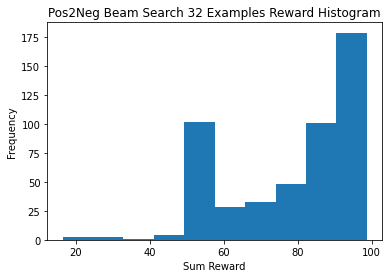

In [19]:
pos2neg_results_ref_df.top_reward.plot.hist()
plt.xlabel('Sum Reward')
plt.title('Pos2Neg Beam Search 32 Examples Reward Histogram')

In [6]:
# beam search 32 examples
pos2neg_results_ref_df.mean() 

<ipython-input-6-a10c05581cd8>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         78.094842
top_recon          73.697869
top_selfbleu       55.377997
top_style           0.824918
sample_id         249.500000
top_perplexity      3.575150
ref_bleu           22.575225
style_acc           0.800000
style_prob          0.767133
dtype: float64

In [9]:
# 128 samples
pos2neg_results_ref_df.mean()

<ipython-input-9-e1d9111e0b93>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         84.672916
top_recon          70.794449
top_selfbleu       45.559608
top_style           0.985514
sample_id         249.500000
top_perplexity      3.681374
ref_bleu           21.237243
style_acc           0.956000
style_prob          0.924958
dtype: float64

In [6]:
# 32 samples
pos2neg_results_ref_df.mean()

<ipython-input-6-7ce3f5a526c9>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pos2neg_results_ref_df.mean()


top_reward         79.404200
top_recon          60.381966
top_selfbleu       34.155176
top_style           0.984264
sample_id         249.500000
top_perplexity      3.763766
ref_bleu           16.619691
style_acc           0.956000
style_prob          0.936692
dtype: float64

In [9]:
task = 'neg2pos'
sample_size = 32
top_k = 10
neg2pos_output = generator.sample_generate(task, sample_size, top_k=top_k, top_p=None)
neg2pos_results_ref_df = evaluator.evaluate_output(task, neg2pos_output)
neg2pos_results_ref_df.to_csv(f'outputs/{task}_prompted_{model_name}_{sample_size}_sample_top_{top_k}.csv', index=False)

0it [00:00, ?it/s]/opt/conda/envs/sql-test/lib/python3.8/site-packages/transformers/pipelines/base.py:996: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
500it [06:14,  1.34it/s]


Computing perplexity...


100%|██████████| 500/500 [00:04<00:00, 112.26it/s]


Comparing with reference...


100%|██████████| 500/500 [00:00<00:00, 4823.01it/s]


Running test classifier


100%|██████████| 500/500 [00:03<00:00, 137.68it/s]


In [10]:
neg2pos_results_ref_df.mean()

<ipython-input-10-8f6d6a6aea31>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  neg2pos_results_ref_df.mean()


top_reward         75.045309
top_recon          52.283863
top_selfbleu       18.408497
top_style           0.978068
sample_id         249.500000
top_perplexity      3.366519
ref_bleu           13.080627
style_acc           0.952000
style_prob          0.935809
dtype: float64

In [32]:
from tqdm import tqdm
neg2pos_ref_output = []
for i, (src, ref) in tqdm(enumerate(zip(generator.sentence_dict['src_neg2pos'],
                                        evaluator.sentence_dict['ref_neg2pos']))): 
    output = generator._select_output([ref],
                                       [src], 
                                       'LABEL_1', 
                                       sample_id=i)
    neg2pos_ref_output.append(output)

500it [00:13, 38.04it/s]


In [33]:
neg2pos_ref_results_ref_df = evaluator.evaluate_output('neg2pos', neg2pos_ref_output)
neg2pos_ref_results_ref_df.mean()

  2%|▏         | 11/500 [00:00<00:04, 105.88it/s]

Computing perplexity...


  0%|          | 0/500 [00:00<?, ?it/s]

Comparing with reference...
Running test classifier


100%|██████████| 500/500 [00:03<00:00, 126.51it/s]


top_reward         63.431108
top_recon          61.683333
top_selfbleu       31.320761
top_style           0.651789
sample_id         249.500000
top_perplexity      3.528815
ref_bleu          100.000000
style_acc           0.634000
style_prob          0.634580
dtype: float64

In [19]:
# top-10 sampling 32 examples again
neg2pos_results_ref_df.mean() 

<ipython-input-19-29383d85f72c>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  neg2pos_results_ref_df.mean()


top_reward         80.370580
top_recon          62.374734
top_selfbleu       37.855323
top_style           0.983664
sample_id         249.500000
top_perplexity      3.690289
ref_bleu           19.030533
style_acc           0.978000
style_prob          0.960074
dtype: float64

In [10]:
# top-10 sampling 32 examples again
neg2pos_results_ref_df.mean() 

<ipython-input-10-ab681ccd67d4>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  neg2pos_results_ref_df.mean()


top_reward         75.131291
top_recon          51.296794
top_selfbleu       22.884512
top_style           0.989658
sample_id         249.500000
top_perplexity      3.326603
ref_bleu           13.254658
style_acc           0.992000
style_prob          0.981427
dtype: float64

Text(0.5, 1.0, 'Neg2Pos Beam Search 32 Examples Reward Histogram')

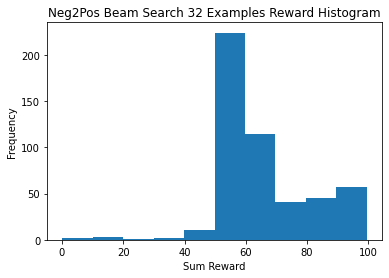

In [20]:
neg2pos_results_ref_df.top_reward.plot.hist()
plt.xlabel('Sum Reward')
plt.title('Neg2Pos Beam Search 32 Examples Reward Histogram')

In [16]:
# beam search 32 examples
neg2pos_results_ref_df.mean()

<ipython-input-16-06102e23d348>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  neg2pos_results_ref_df.mean()


top_reward         63.910591
top_recon          60.802694
top_selfbleu       46.236360
top_style           0.670185
sample_id         249.500000
top_perplexity      2.946075
ref_bleu           17.782526
style_acc           0.664000
style_prob          0.658772
dtype: float64

In [11]:
# 128 samples
neg2pos_results_ref_df.mean()

<ipython-input-11-0a9523e3f8c5>:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  neg2pos_results_ref_df.mean()


top_reward         80.357665
top_recon          62.463926
top_selfbleu       37.580714
top_style           0.982514
sample_id         249.500000
top_perplexity      3.597255
ref_bleu           18.219841
style_acc           0.982000
style_prob          0.962805
dtype: float64

In [7]:
# 32 samples
neg2pos_results_ref_df.mean()

<ipython-input-7-8f6d6a6aea31>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  neg2pos_results_ref_df.mean()


top_reward         75.241616
top_recon          51.810439
top_selfbleu       23.752992
top_style           0.986728
sample_id         249.500000
top_perplexity      3.473505
ref_bleu           13.653770
style_acc           0.982000
style_prob          0.969258
dtype: float64

In [23]:
pd.DataFrame(neg2pos_output).mean()

<ipython-input-23-c381d5bee5bd>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pd.DataFrame(neg2pos_output).mean()


top_reward       63.910591
top_recon        60.802693
top_selfbleu     46.236360
top_style         0.670185
sample_id       249.500000
dtype: float64

In [11]:
neg2pos_results_ref_df.mean()

<ipython-input-11-8f6d6a6aea31>:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  neg2pos_results_ref_df.mean()


top_reward         75.076161
top_recon          51.583279
top_selfbleu       22.311458
top_style           0.985690
sample_id         249.500000
top_perplexity      3.396032
ref_bleu           13.465223
style_acc           0.992000
style_prob          0.975662
dtype: float64

In [1]:
from evaluator import Evaluator
from style_transformer import StyleTransformerGenerator
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', 100)

In [2]:
generator = StyleTransformerGenerator(1)
evaluator = Evaluator(0)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaModel: ['lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
task = 'pos2neg'
sample_size = 128
top_k = 10
pos2neg_output = generator.sample_generate(task, sample_size, top_k=top_k, top_p=None)
pos2neg_results_ref_df = evaluator.evaluate_output(task, pos2neg_output)
pos2neg_results_ref_df.to_csv(f'outputs/{task}_style_transformer_{sample_size}_sample_top_{top_k}.csv', index=False)

500it [11:50,  1.42s/it]
  3%|▎         | 13/500 [00:00<00:03, 128.00it/s]

Computing perplexity...


  0%|          | 0/500 [00:00<?, ?it/s]

Comparing with reference...
Running test classifier


100%|██████████| 500/500 [00:03<00:00, 131.54it/s]


In [6]:
pos2neg_results_ref_df.mean()

top_reward         90.431967
top_recon          81.282084
top_selfbleu       62.976927
top_style           0.995818
sample_id         249.500000
top_perplexity      3.993088
ref_bleu           28.411292
style_acc           0.976000
style_prob          0.960646
dtype: float64

In [8]:
task = 'neg2pos'
sample_size = 128
top_k = 10
neg2pos_output = generator.sample_generate(task, sample_size, top_k=top_k, top_p=None)
neg2pos_results_ref_df = evaluator.evaluate_output(task, neg2pos_output)
neg2pos_results_ref_df.to_csv(f'outputs/{task}_style_transformer_{sample_size}_sample_top_{top_k}.csv', index=False)

0it [00:00, ?it/s]/opt/conda/envs/style-transformer/lib/python3.6/site-packages/transformers/pipelines/base.py:998: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,
500it [11:50,  1.42s/it]
  3%|▎         | 14/500 [00:00<00:03, 132.09it/s]

Computing perplexity...


  0%|          | 0/500 [00:00<?, ?it/s]

Comparing with reference...
Running test classifier


100%|██████████| 500/500 [00:03<00:00, 129.73it/s]


In [9]:
neg2pos_results_ref_df.mean()

top_reward         86.098998
top_recon          73.925316
top_selfbleu       60.674030
top_style           0.982727
sample_id         249.500000
top_perplexity      4.654884
ref_bleu           27.332451
style_acc           0.976000
style_prob          0.950812
dtype: float64

In [9]:
# 32 sample another time
neg2pos_results_ref_df.mean()

top_reward         83.991034
top_recon          71.251966
top_selfbleu       58.939303
top_style           0.967301
sample_id         249.500000
top_perplexity      4.729528
ref_bleu           27.383497
style_acc           0.948000
style_prob          0.935196
dtype: float64

In [10]:
neg2pos_results_ref_df.mean()

top_reward         83.938927
top_recon          71.860167
top_selfbleu       59.367303
top_style           0.960177
sample_id         249.500000
top_perplexity      4.728543
ref_bleu           27.169537
style_acc           0.952000
style_prob          0.933362
dtype: float64